# Notebook similar to main.py in order to compare several methods of photo-z estimation

## User inputs

In [1]:
delight_dir                = 'Delight'                        # directory where Delight is installed, relative should work.
desc_dir                   = 'desc-dc2'                       # subdir of Delight dir, for specific use. If none, use an empty string ""
delight_paramDir           = 'tmp'                            # subdir of descDir
delight_runFile            = 'run_delight_descdc2.py'         # usually in descDir
delight_paramFile          = 'parameters_DESC-DC2.cfg'        # usually in paramDir
test_filename              = 'PhotoZML/data/test_dc2_validation_9816.hdf5'   # relative path
train_filename             = 'PhotoZML/data/test_dc2_training_9816.hdf5' # relative path
#test_fileout_delight       = 'test_gal_fluxredshifts.txt'     # file name only - will be created in the appropriate directory, until this is automated
#train_fileout_delight      = 'train_gal_fluxredshifts.txt'    # file name only - will be created in the appropriate directory, until this is automated
lephare_dir                = 'LEPHARELSST'                    # relative path - should be the directory where LSST.para and runLePhareLSST.sh are located and run.
test_fileout_lephare       = 'test_DC2_VALID_CAT_IN.in'       # file name only - will be created in the appropriate directory, until this is automated
train_fileout_lephare      = 'train_DC2_VALID_CAT_IN.in'      # file name only - will be created in the appropriate directory, until this is automated
mag_filt                   = 31.8
snr_filt                   = 5.0
vc, vl, alC, alL           = 0.1, 0.1, 1e3, 1e2
ellPriorSigma, zPriorSigma = 0.5, 0.2
nb_est                     = 50
reg_depth                  = 30

photoZML_name='regrnPhotoZ.txt'
pdfOutput_name='plotFileOut.pdf'

## Imports

In [2]:
import os, sys, time, subprocess
#import tables as tb
#import pandas as pd
import h5py
import numpy as np
from astropy.table import Table   #astropy routine for reading tables
import matplotlib.pyplot as plt   #plotting routines
from matplotlib.backends.backend_pdf import PdfPages

# Random forest routine from scikit-learn:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# Cross-Validation routines:
#from sklearn.cross_validation import KFold, train_test_split, cross_val_predict
from sklearn.model_selection import KFold, train_test_split, cross_val_predict
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Useful Delight routines:
sys.path.append(os.path.realpath(os.path.normpath(os.path.join('./', delight_dir))))
from delight.io import *
from delight.utils import *
from utils import *

%matplotlib inline

## Generate the inputs

### Delight and LePhare paths

In [3]:
print("Generating the inputs")
t_start=time.time()
delight_absRunFile=os.path.realpath(os.path.normpath(os.path.join("./", delight_dir, desc_dir, delight_runFile)))
delight_absParamFile=os.path.realpath(os.path.normpath(os.path.join("./", delight_dir, desc_dir, delight_paramDir, delight_paramFile)))
execDir = os.path.realpath(os.getcwd())
os.chdir(os.path.realpath(os.path.normpath(os.path.join("./", delight_dir, desc_dir))))
params = parseParamFile(delight_absParamFile, verbose=False, catFilesNeeded=False)
os.chdir(execDir)
test_fileout_delight = params['target_catFile']
train_fileout_delight = params['training_catFile']
testFile_absPath=os.path.realpath(os.path.normpath(os.path.join("./", test_filename)))
trainFile_absPath=os.path.realpath(os.path.normpath(os.path.join("./", train_filename)))
delight_testFileoutAbs=os.path.realpath(os.path.normpath(os.path.join("./", delight_dir, desc_dir, test_fileout_delight)))
#print('Delight test file:\n\t{}'.format(delight_testFileoutAbs))
delight_trainFileoutAbs=os.path.realpath(os.path.normpath(os.path.join("./", delight_dir, desc_dir, train_fileout_delight)))
lephare_testFileoutAbs=os.path.realpath(os.path.normpath(os.path.join("./", lephare_dir, test_fileout_lephare)))
lephare_trainFileoutAbs=os.path.realpath(os.path.normpath(os.path.join("./", lephare_dir, train_fileout_lephare)))

Generating the inputs


### Generate the data as text files for Delight and LePhare and numpy arrays for ML

In [4]:
test_data_mags, test_err_mags, test_data_colors, test_data_colmag, test_z, dummy1, dummy2 =\
    create_all_inputs(testFile_absPath,\
                      mag=mag_filt,\
                      snr=snr_filt,\
                      returnErrors=True,\
                      fileout_lephare=lephare_testFileoutAbs,\
                      fileout_delight=delight_testFileoutAbs)

train_data_mags, train_err_mags, train_data_colors, train_data_colmag, train_z, dummy3, dummy4 =\
    create_all_inputs(trainFile_absPath,\
                      mag=mag_filt,\
                      snr=snr_filt,\
                      returnErrors=True,\
                      fileout_lephare=lephare_trainFileoutAbs,\
                      fileout_delight=delight_trainFileoutAbs)

U-Magnitude filter: (20449, 15) original, (1503, 15) removed, (18946, 15) left (20449 total for check).
SNR filter: (11394,) bad indexes, (7552, 15) left (18946 total for check).
(7552, 1)
Magnitudes, magnitude errors, colors, Colors+mag, Spectro-Z for ML ; input CAT file for LEPHARE ; input flux-redshift file for Delight :
U-Magnitude filter: (10225, 15) original, (722, 15) removed, (9503, 15) left (10225 total for check).
SNR filter: (5748,) bad indexes, (3755, 15) left (9503 total for check).
(3755, 1)
Magnitudes, magnitude errors, colors, Colors+mag, Spectro-Z for ML ; input CAT file for LEPHARE ; input flux-redshift file for Delight :


In [5]:
# DEBUG #
#print(test_data_mags.shape, test_data_colors.shape, test_data_colmag.shape, test_z.shape, lephare_testFileoutAbs, delight_testFileoutAbs)
#print(train_data_mags.shape, train_data_colors.shape, train_data_colmag.shape, train_z.shape, lephare_trainFileoutAbs, delight_trainFileoutAbs)
# END DEBUG #

t_init=time.time()
print('Input creation duration: {} s'.format(t_init-t_start))

Input creation duration: 0.847855806350708 s


## Run the estimators

### Run Delight

In [6]:
runDelight=False

In [7]:
# Run Delight - call the appropriate python fonctions
if runDelight:
    os.chdir(os.path.realpath(os.path.normpath(os.path.join("./", delight_dir, desc_dir))))
    print('DEBUG - current working directory:\n\t {}'.format(os.getcwd()))
    sys.path.append(os.getcwd())
    from run_full_delight_confFile import run_full_delight_confFile
    print('Running Delight - please be patient.')
    run_full_delight_confFile(delight_absParamFile)
    os.chdir(execDir)
else:
    print('Skip Delight')
t_endDelight=time.time()
print('Delight complete. Duration: {} s'.format(t_endDelight-t_init))

Skip Delight
Delight complete. Duration: 0.047586917877197266 s


### Run LePHARE++

In [8]:
runLePhare=False

In [10]:
# Run LePhare - call the appropriate shell fonctions
os.chdir(execDir)
if runLePhare:
    print('Running LEPHARE++')
    os.chdir(os.path.realpath(os.path.normpath(os.path.join("./", lephare_dir))))
    os.environ['LEPHAREDIR'] = os.path.realpath(os.path.normpath(os.path.join("..", 'LEPHARE')))
    print(os.getcwd())
    os.environ['LEPHAREWORK'] = os.getcwd()
    os.environ['OMP_NUM_THREADS'] = '10'
    os.environ['CAT_FILE_IN'] = lephare_testFileoutAbs
    subprocess.run('./runLePhareLSST.sh')
    os.chdir(execDir)
else:
    print('Skip LEPHARE++')
t_endLePhare=time.time()
print('LEPHARE++ complete. Duration: {} s'.format(t_endLePhare-t_endDelight))

Running LEPHARE++
/pbs/throng/lsst/users/jocheval/Intern2022_PhotoZ/LEPHARELSST
Filter
Number of keywords read in the command line: 0
Number of keywords read in the config file: 105
#######################################
# Build the filter file with the following options: 
# Config file: LSST.para
# FILTER_REP: filt
# FILTER_LIST: lsst_baseline/total_u.pb lsst_baseline/total_g.pb lsst_baseline/total_r.pb lsst_baseline/total_i.pb lsst_baseline/total_z.pb lsst_baseline/total_y.pb 
# TRANS_TYPE: 0 0 0 0 0 0 
# FILTER_CALIB: 0 0 0 0 0 0 
# FILTER_FILE: /pbs/throng/lsst/users/jocheval/Intern2022_PhotoZ/LEPHARELSST/filt/filter_lsst_baseline.dat
# FILTER_FILE.doc: /pbs/throng/lsst/users/jocheval/Intern2022_PhotoZ/LEPHARELSST/filt/filter_lsst_baseline.doc
#######################################
# NAME                        IDENT      Lbda_mean Lbeff(Vega)       FWHM     AB-cor    TG-cor      VEGA M_sun(AB)   CALIB      Lb_eff    Fac_corr
lsst_baseline/total_u.pb      1             0.3670    

Can't open age file none
No selection by age. 


Running with OpenMP on 10 threads!
Number of keywords read in the command line: 1
Number of keywords read in the config file: 105
Do not find the keyword QSO_LIB_IN within the parameter file 
Do not find the keyword STAR_LIB_IN within the parameter file 
Do not find the keyword QSO_LIB_OUT within the parameter file 
Do not find the keyword STAR_LIB_OUT within the parameter file 
 All files opened 
#######################################
# It s computing the SYNTHETIC MAGNITUDES #
# For Gal/QSO libraries with these OPTIONS #
# with the following options :           
# Config file     : LSST.para
# Filter file     : filter_lsst_baseline
# Magnitude type     : AB
# GAL_LIB_IN    :/pbs/throng/lsst/users/jocheval/Intern2022_PhotoZ/LEPHARELSST/lib_bin/LIB_CWW(.doc & .bin)
# GAL_LIB_OUT   :/pbs/throng/lsst/users/jocheval/Intern2022_PhotoZ/LEPHARELSST/lib_mag/CE_CWW(.doc & .bin)
# ZGRID_TYPE   :0
# Z_STEP   :0.01 0.01 3.01
# COSMOLOGY   :70 0.3 0.7
# EXTINC_LAW   :SB_calzetti.dat 
# MOD_EXTINC

### Run Machine Learning

In [11]:
runML=True

In [12]:
# Run the ML - call the appropriate python fonctions
## We need to set up an implementation of the scikit-learn RandomForestRegressor in an object called 'regrn'.
if runML:
    print('Beginning of ML estimation')
    regrn = RandomForestRegressor(n_estimators = nb_est, max_depth = reg_depth, max_features = 'auto')

    ## Train the regressor using the training data
    print('Training estimator')
    regrn.fit(train_data_mags, train_z.ravel())
    t_MLtrain=time.time()

    ## Apply the regressor to predict values for the test data
    print('Applying estimator')
    z_phot = regrn.predict(test_data_mags)
    
    np.savetxt(photoZML_name, np.column_stack((test_z, test_data_mags, z_phot)))
else:
    print('Skip ML')
t_MLpredict=time.time()
print('ML estimation done. Training time: {} s, Estimation time: {} s'.format(t_MLtrain-t_endLePhare, t_MLpredict-t_MLtrain))

Beginning of ML estimation
Training estimator
Applying estimator
ML estimation done. Training time: 80.73063135147095 s, Estimation time: 0.24318432807922363 s


## Evaluation of estimators' performances

### Load results

#### Delight

In [13]:
## Load delight data
### First read a bunch of useful stuff from the parameter file.
dir_seds = os.path.realpath(os.path.normpath(os.path.join("./", delight_dir, desc_dir, params['templates_directory'])))
dir_filters = os.path.realpath(os.path.normpath(os.path.join("./", delight_dir, desc_dir, params['bands_directory'])))
params['bands_directory'] = dir_filters
params['templates_directory'] = dir_seds
bandCoefAmplitudes, bandCoefPositions, bandCoefWidths, norms = readBandCoefficients(params)
bandNames = params['bandNames']
numBands, numCoefs = bandCoefAmplitudes.shape
fluxredshifts = np.loadtxt(delight_testFileoutAbs)
fluxredshifts_train = np.loadtxt(delight_trainFileoutAbs)
bandIndices, bandNames, bandColumns, bandVarColumns, redshiftColumn, refBandColumn = readColumnPositions(params, prefix='target_')
redshiftDistGrid, redshiftGrid, redshiftGridGP = createGrids(params)
lambdaRef = params['lambdaRef']
sed_names = params['templates_names']
nt = len(sed_names)
f_mod = np.zeros((redshiftGrid.size, nt, len(params['bandNames'])))
for t, sed_name in enumerate(sed_names):
    f_mod[:, t, :] = np.loadtxt(os.path.join(dir_seds, sed_name + '_fluxredshiftmod.txt'))
    
### Load the PDF files
metrics = np.loadtxt(os.path.realpath(os.path.normpath(os.path.join("./", delight_dir, desc_dir, params['metricsFile']))))
metricscww = np.loadtxt(os.path.realpath(os.path.normpath(os.path.join("./", delight_dir, desc_dir, params['metricsFileTemp']))))
# Those of the indices of the true, mean, stdev, map, and map_std redshifts.
i_zt, i_zm, i_std_zm, i_zmap, i_std_zmap = 0, 1, 2, 3, 4
i_ze = i_zm
i_std_ze = i_std_zm
pdfs = np.loadtxt(os.path.realpath(os.path.normpath(os.path.join("./", delight_dir, desc_dir, params['redshiftpdfFile']))))
pdfs_cww = np.loadtxt(os.path.realpath(os.path.normpath(os.path.join("./", delight_dir, desc_dir, params['redshiftpdfFileTemp']))))
pdfatZ_cww = metricscww[:, 5] / pdfs_cww.max(axis=1)
pdfatZ = metrics[:, 5] / pdfs.max(axis=1)
nobj = pdfatZ.size
print('nobj = {}'.format(nobj))
pdfs /= np.trapz(pdfs, x=redshiftGrid, axis=1)[:, None]
pdfs_cww /= np.trapz(pdfs_cww, x=redshiftGrid, axis=1)[:, None]

nobj = 7552


#### LePhare++

In [14]:
## Load the results from LEPHARE
fileIn=os.path.realpath(os.path.normpath(os.path.join('./', lephare_dir, 'zphot_long.out')))

### Number of the filter start at 0
selFilt=0   # filter for the selection in mag
uFilt=0
gFilt=1
rFilt=2
iFilt=3
zFilt=4
yFilt=5

### Array in redshift and mag, isolate extreme values
range_z = [0,1,2,3,6]
z_min, z_max = np.amin(range_z), np.amax(range_z)
range_mag = [15.,22.5,23.5,25,28]
mag_min, mag_max = np.amin(range_mag), np.amax(range_mag)

### READ THE INPUT FILE
### Read the first argument with the name of the photo-z output catalogue
catIn=open(fileIn,'r')
print("Name of the photo-z catalogue : ", fileIn)

### Loop over the filters
nbFilt=6
magst=""
idmagst=""
### create the string to read the mag
for i in range(nbFilt) :
    magst=magst+",mag"+str(i)
    idmagst=idmagst+","+str(i+20)
### create the string to read the error mag
for i in range(nbFilt) :
    magst=magst+",emag"+str(i)
    idmagst=idmagst+","+str(i+20+nbFilt)
### create the string to read the kcor
for i in range(nbFilt) :
    magst=magst+",kcor"+str(i)
    idmagst=idmagst+","+str(i+20+2*nbFilt)
### create the string to read the absolute mag
for i in range(nbFilt) :
    magst=magst+",absmag"+str(i)
    idmagst=idmagst+","+str(i+20+3*nbFilt)
### create the string to read the uncertainties on absolute mag
for i in range(nbFilt) :
    magst=magst+",eabsmag"+str(i)
    idmagst=idmagst+","+str(i+20+4*nbFilt)
### create the string for absolute mag filters
for i in range(nbFilt) :
    magst=magst+",mabsfilt"+str(i)
    idmagst=idmagst+","+str(i+20+5*nbFilt)

lastIdMagst=int(idmagst.split(',')[-1])
lastString=",{},{},{},{}".format(lastIdMagst+1, lastIdMagst+2, lastIdMagst+3, lastIdMagst+4)

### Extract from the ascii file
commandst = "Id,zp,zl68,zu68,zml,zmll68,zmlu68,chi,mod,law,ebv,zp2,chi2,mod2,ebv2,zq,chiq,modq,mods,chis"+magst+",scale,nbFilt,context,zs= np.loadtxt(catIn, dtype='float', usecols=(0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19"+idmagst+lastString+"), unpack=True )"

### transform the string into a command
print(commandst)
exec(commandst)

### CONDITION FOR SELECTION
### Mag use to select the sample
mag=eval("mag"+str(selFilt))
### General condition to select the galaxies in the expected z/mag range
cond = (zp>z_min) & (zp<z_max) & (mag>mag_min) & (mag<mag_max) 
### condition to select stars
condstar = (chis<chi)
### condition to select galaxies
condgal =  (~condstar)
### condition to select spectroscopic redshifts
condspec = (zs>0) & (zs<9)

### Load the PDZ from LEPHARE
pdzOut = os.path.realpath(os.path.normpath(os.path.join("./", lephare_dir, 'pdzOut.pdz')))
pdzRange = np.arange(0.01, 3.02, 0.01)
pdzRange = np.concatenate((np.array([0.0]), pdzRange, np.array([3.01])))
pdzPhare = np.loadtxt(pdzOut)

Name of the photo-z catalogue :  /pbs/throng/lsst/users/jocheval/Intern2022_PhotoZ/LEPHARELSST/zphot_long.out
Id,zp,zl68,zu68,zml,zmll68,zmlu68,chi,mod,law,ebv,zp2,chi2,mod2,ebv2,zq,chiq,modq,mods,chis,mag0,mag1,mag2,mag3,mag4,mag5,emag0,emag1,emag2,emag3,emag4,emag5,kcor0,kcor1,kcor2,kcor3,kcor4,kcor5,absmag0,absmag1,absmag2,absmag3,absmag4,absmag5,eabsmag0,eabsmag1,eabsmag2,eabsmag3,eabsmag4,eabsmag5,mabsfilt0,mabsfilt1,mabsfilt2,mabsfilt3,mabsfilt4,mabsfilt5,scale,nbFilt,context,zs= np.loadtxt(catIn, dtype='float', usecols=(0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59), unpack=True )


#### Machine Learning

In [15]:
test_z=np.loadtxt(photoZML_name)[:, 0]
z_phot=np.loadtxt(photoZML_name)[:, -1]
test_data_mags=np.loadtxt(photoZML_name)[:, 1:-1]

### Plots: photo-z = f(spectro-z)

DEBUG: zphot size = (7552,), zspec size = (7552,)
Random Forest Regressor :
Standard Deviation: 0.0595
Standard Deviation Uncertainty: 0.0005
Normalized MAD: 0.0328
Delta z >0.15(1+z) outliers:  3.085 percent
Median offset:  0.001 +/-  0.001




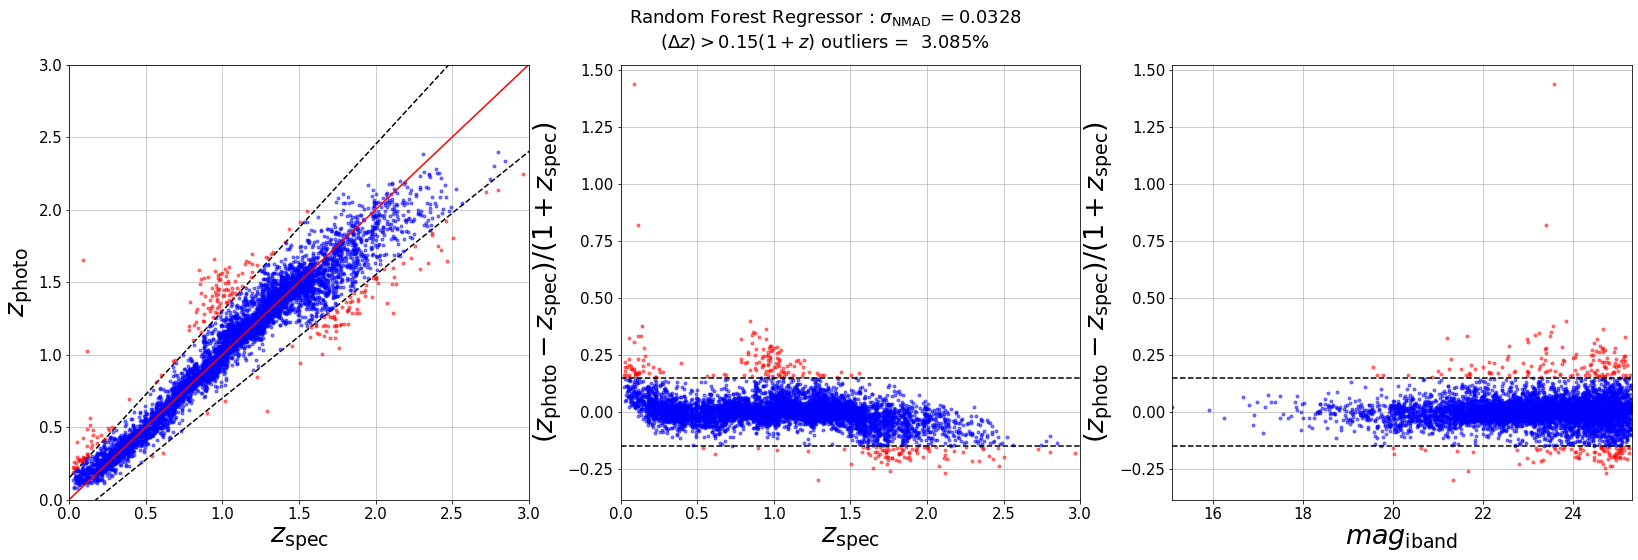

In [16]:
figZsZp_ML = plot_and_stats(test_z, z_phot, test_data_mags[:, 3], title='Random Forest Regressor')

DEBUG: zphot size = (7552,), zspec size = (7552,)
LEPHARE++ :
Standard Deviation: 0.3276
Standard Deviation Uncertainty: 0.0027
Normalized MAD: 0.0667
Delta z >0.15(1+z) outliers: 11.679 percent
Median offset:  0.002 +/-  0.005




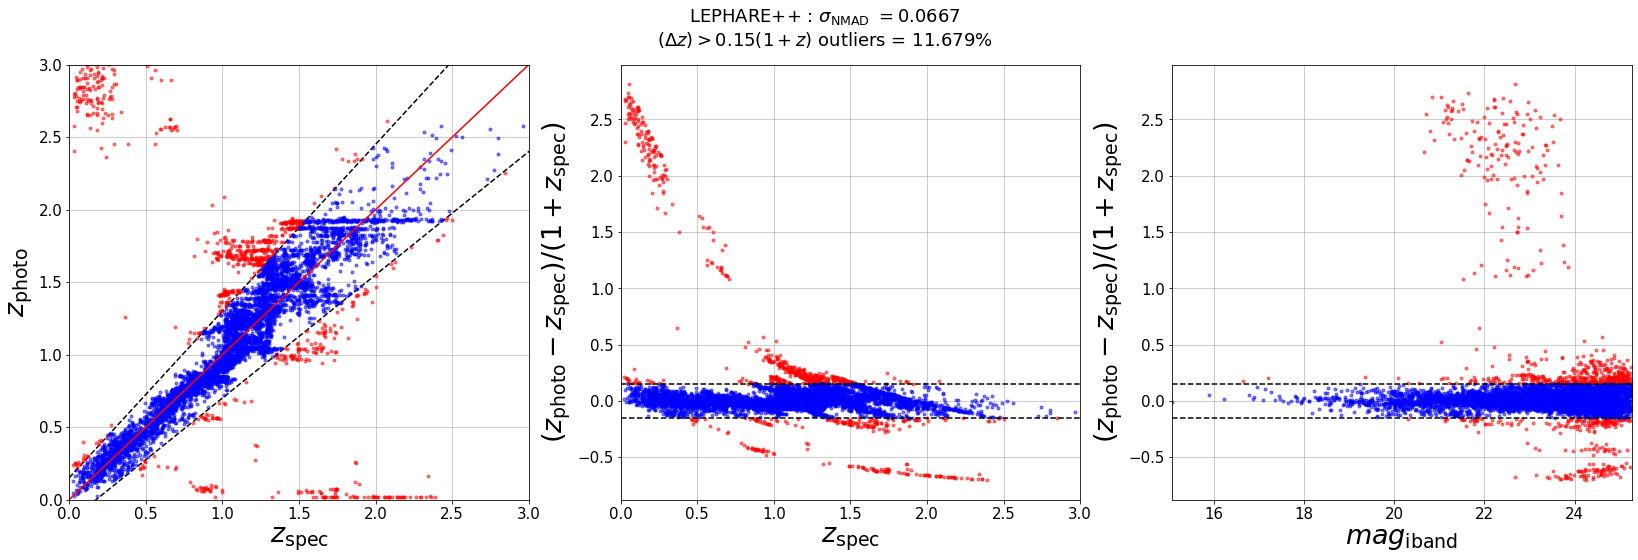

In [17]:
figZsZp_lephare = plot_and_stats(zs, zp, mag3, title='LEPHARE++')

DEBUG: zphot size = (7552,), zspec size = (7552,)
Delight TF :
Standard Deviation: 0.2998
Standard Deviation Uncertainty: 0.0024
Normalized MAD: 0.0623
Delta z >0.15(1+z) outliers: 10.567 percent
Median offset: -0.009 +/-  0.004




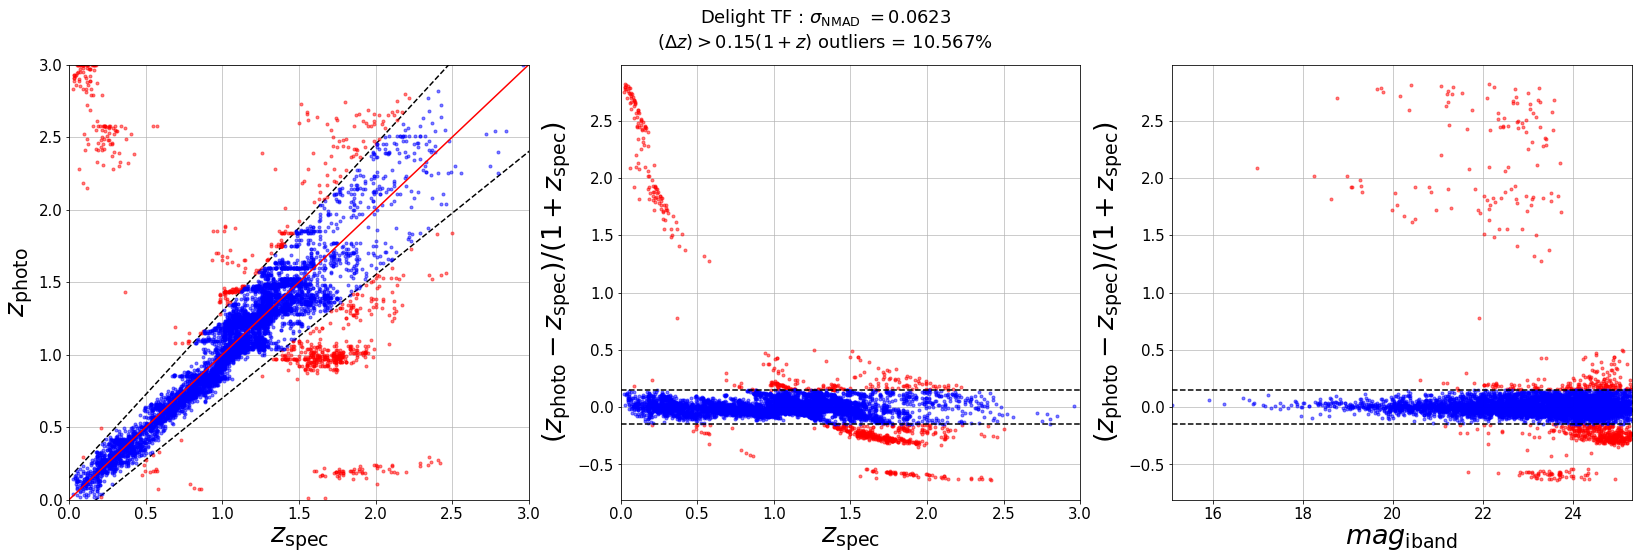

In [18]:
figZsZp_delightTF = plot_and_stats(metricscww[:, i_zt], metricscww[:, i_zmap], test_data_mags[:, 3], title='Delight TF')

DEBUG: zphot size = (7552,), zspec size = (7552,)
Delight TF+GP :
Standard Deviation: 0.0995
Standard Deviation Uncertainty: 0.0008
Normalized MAD: 0.0608
Delta z >0.15(1+z) outliers:  8.488 percent
Median offset: -0.012 +/-  0.001




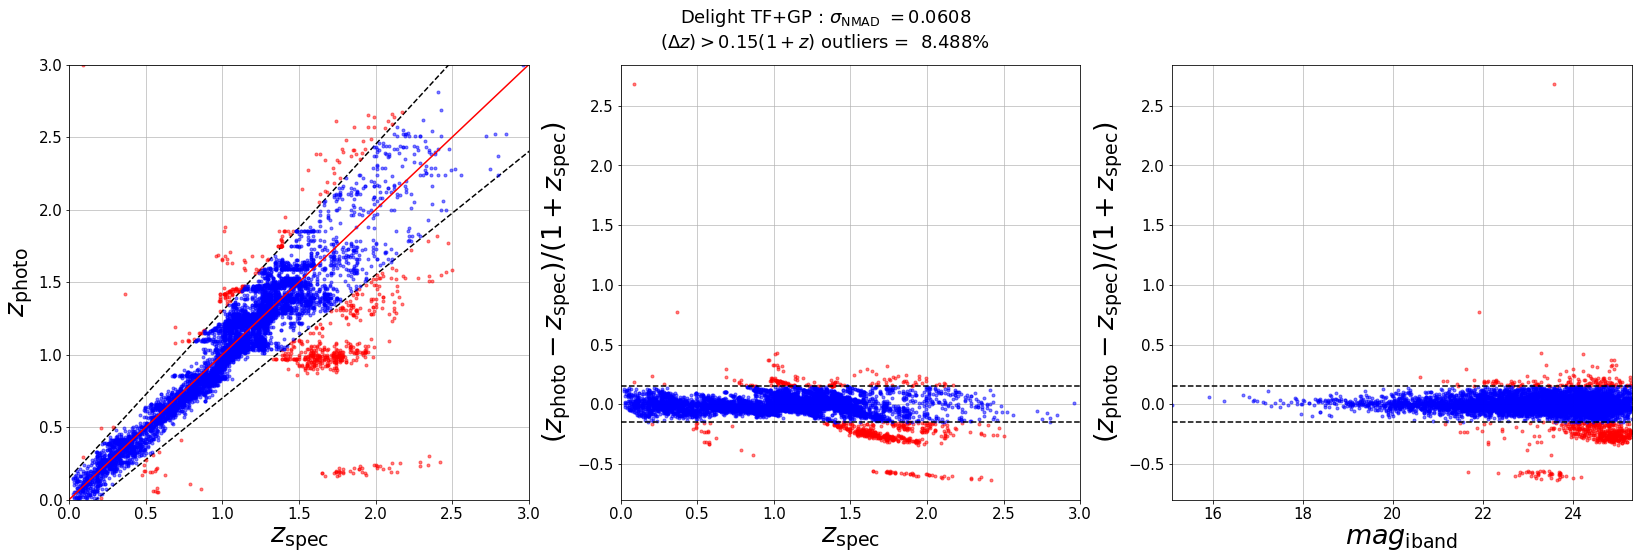

In [19]:
figZsZp_delightGP = plot_and_stats(metrics[:, i_zt], metrics[:, i_zmap], test_data_mags[:, 3], title='Delight TF+GP')

### Random probability distribution plots

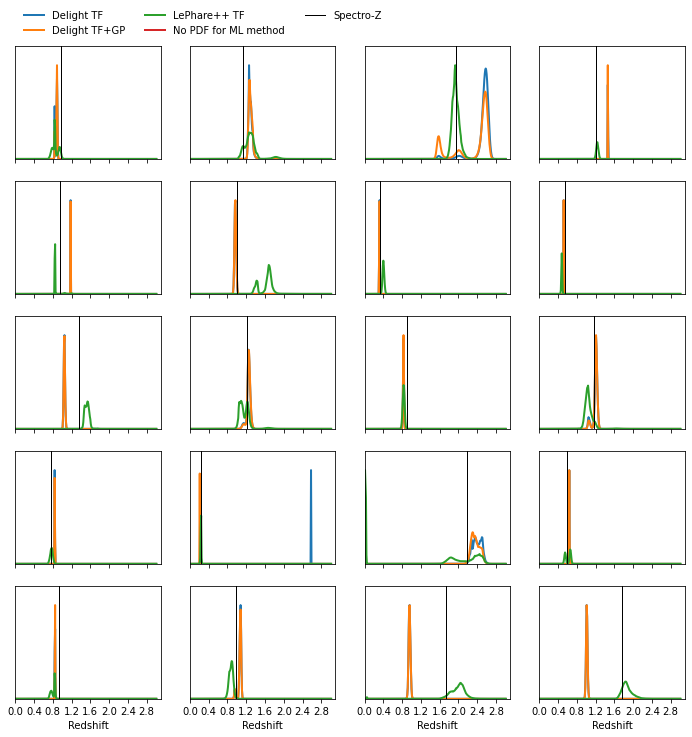

In [20]:
ncol = 4
figRandPdz, axsRandPdz = plt.subplots(5, ncol, figsize=(12, 12), sharex=True, sharey=False)
axsRandPdz = axsRandPdz.ravel()
sel = np.random.choice(nobj, axsRandPdz.size, replace=False)
lw = 2
for ik in range(axsRandPdz.size):
    k = sel[ik]
    zspec=fluxredshifts[k, redshiftColumn]
    #print(zspec, np.where(zs == zspec))
    dummy=np.array([])
    for z in zs:
        dummy=np.append(dummy, (z-zspec))
    dummy=np.absolute(dummy)
    galId=Id[np.argmin(dummy)]
    axsRandPdz[ik].plot(redshiftGrid, pdfs_cww[k,:], lw=lw, label='Delight TF')
    axsRandPdz[ik].plot(redshiftGrid, pdfs[k,:], lw=lw, label='Delight TF+GP')
    axsRandPdz[ik].plot(pdzRange, pdzPhare[k, 1:], lw=lw, label='LePhare++ TF')
    axsRandPdz[ik].plot([], [], lw=lw, label="No PDF for ML method")
    axsRandPdz[ik].axvline(zspec, c="k", lw=1, label='Spectro-Z')
    ymax = np.max(np.concatenate((pdfs_cww[k,:], pdfs[k,:], pdzPhare[np.argmin(dummy), 1:], [])))
    axsRandPdz[ik].set_ylim([0, ymax*1.2])
    axsRandPdz[ik].set_xlim([0, 3.1])
    axsRandPdz[ik].set_yticks([])
    axsRandPdz[ik].set_xticks([0.0, 0.4, 0.8, 1.2, 1.6, 2.0, 2.4, 2.8])
for i in range(ncol):
    axsRandPdz[-i-1].set_xlabel('Redshift', fontsize=10)
axsRandPdz[0].legend(ncol=3, frameon=False, loc='upper left', bbox_to_anchor=(0.0, 1.4))

### Save the figures if needed

In [21]:
# store the figure in individual images - only if activated by the user
if 0:
    figZsZp_ML.savefig('figZsZp_ML.png')
    figZsZp_lephare.savefig('figZsZp_lephare.png')
    figZsZp_delightTF.savefig('figZsZp_delightTF.png')
    figZsZp_delightGP.savefig('figZsZp_delightGP.png')
    figRandPdz.savefig('figRandPdz.png')

In [22]:
# store the figure in a PDF - only if activated by the user
# All the figures will be collected in a single pdf file 
if 0:
    pdfOut = PdfPages(pdfOutput_name)
    figZsZp_ML.savefig(pdfOut,format='pdf')
    figZsZp_lephare.savefig(pdfOut,format='pdf')
    figZsZp_delightTF.savefig(pdfOut,format='pdf')
    figZsZp_delightGP.savefig(pdfOut,format='pdf')
    figRandPdz.savefig(pdfOut,format='pdf')
    pdfOut.close()

### Various metrics - from sklearn

In [23]:
r2_ML = r2_score(z_phot, test_z)
mae_ML = mean_absolute_error(z_phot, test_z)
mse_ML = np.sqrt(mean_squared_error(z_phot, test_z))
print('Random Forest Regressor:\nR2 score: {}, Mean Absolute Error: {}, Mean Squared Error: {}'.format(r2_ML, mae_ML, mse_ML))

Random Forest Regressor:
R2 score: 0.9160806656424939, Mean Absolute Error: 0.07772139360571884, Mean Squared Error: 0.1273628184588514


In [24]:
r2_GP = r2_score(metrics[:, i_zmap], metrics[:, i_zt])
mae_GP = mean_absolute_error(metrics[:, i_zmap], metrics[:, i_zt])
mse_GP = np.sqrt(mean_squared_error(metrics[:, i_zmap], metrics[:, i_zt]))
print('Delight-GP:\nR2 score: {}, Mean Absolute Error: {}, Mean Squared Error: {}'.format(r2_GP, mae_GP, mse_GP))

Delight-GP:
R2 score: 0.718619485343519, Mean Absolute Error: 0.1425359904661017, Mean Squared Error: 0.24780319155578495


In [25]:
r2_TF = r2_score(metricscww[:, i_zmap], metricscww[:, i_zt])
mae_TF = mean_absolute_error(metricscww[:, i_zmap], metricscww[:, i_zt])
mse_TF = np.sqrt(mean_squared_error(metricscww[:, i_zmap], metricscww[:, i_zt]))
print('Delight-TF:\nR2 score: {}, Mean Absolute Error: {}, Mean Squared Error: {}'.format(r2_TF, mae_TF, mse_TF))

Delight-TF:
R2 score: 0.3405872042041851, Mean Absolute Error: 0.18870651483050846, Mean Squared Error: 0.41840030095659825


In [26]:
r2_LP = r2_score(zp, zs)
mae_LP = mean_absolute_error(zp, zs)
mse_LP = np.sqrt(mean_squared_error(zp, zs))
print('LEPHARE++:\nR2 score: {}, Mean Absolute Error: {}, Mean Squared Error: {}'.format(r2_LP, mae_LP, mse_LP))

LEPHARE++:
R2 score: 0.3061663832200294, Mean Absolute Error: 0.20173569253177964, Mean Squared Error: 0.4571652657758448


### Overfitting?

DEBUG: zphot size = (3755,), zspec size = (3755,)
Random Forest Regressor on training data :
Standard Deviation: 0.0235
Standard Deviation Uncertainty: 0.0003
Normalized MAD: 0.0125
Delta z >0.15(1+z) outliers:  0.053 percent
Median offset:  0.001 +/-  0.000


Random Forest Regressor on training data:
R2 score: 0.9882609573661001, Mean Absolute Error: 0.029870808281404218, Mean Squared Error: 0.04959107673684666


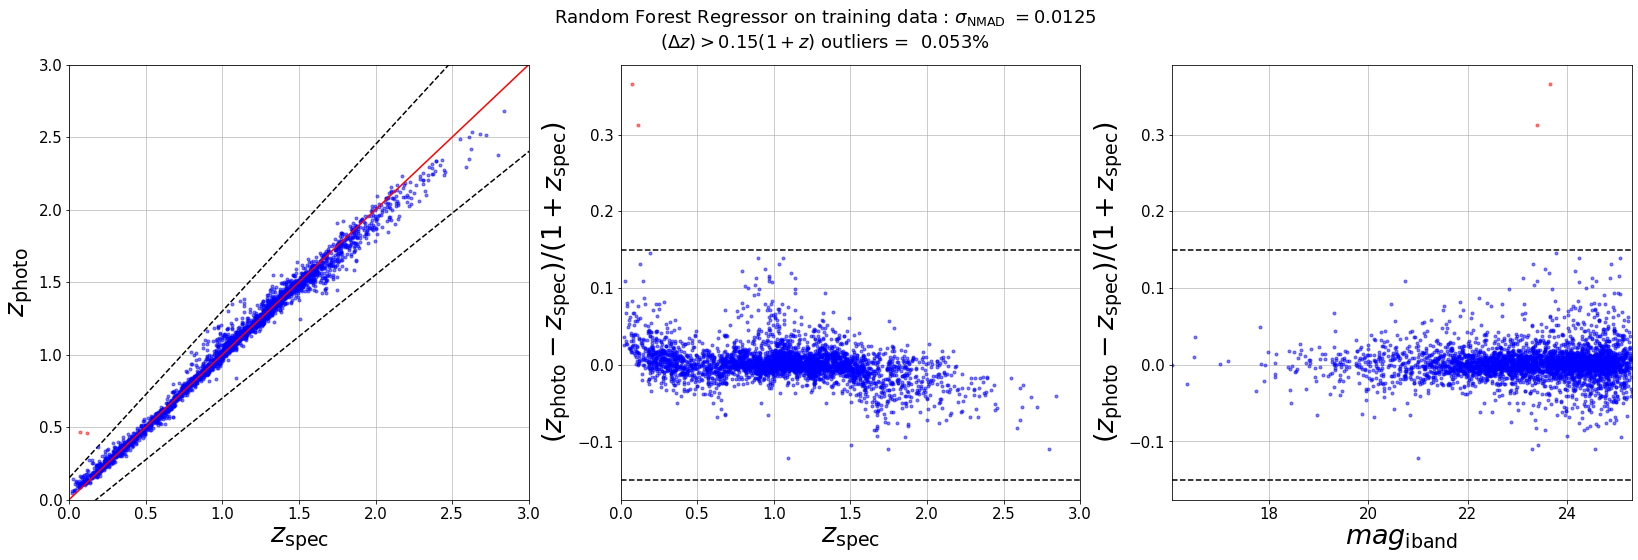

In [28]:
z_phot_train = regrn.predict(train_data_mags) ### Requires regrn to exist, i.e. runML = True and cells above have been run
plot_and_stats(train_z.ravel(), z_phot_train, train_data_mags[:, 3], title='Random Forest Regressor on training data')
r2_ML_train = r2_score(z_phot_train, train_z)
mae_ML_train = mean_absolute_error(z_phot_train, train_z)
mse_ML_train = np.sqrt(mean_squared_error(z_phot_train, train_z))
print('Random Forest Regressor on training data:\nR2 score: {}, Mean Absolute Error: {}, Mean Squared Error: {}'.format(r2_ML_train, mae_ML_train, mse_ML_train))

## Alternate methods and research for improvements

In [31]:
regrn_bis = RandomForestRegressor(n_estimators = nb_est, max_depth = reg_depth, max_features = .25)
train_data_all=np.column_stack((train_data_mags, train_err_mags, train_data_colors)) ## add errors as well ! need to modify utils.py
regrn_bis.fit(train_data_all, train_z.ravel())
test_data_all = np.column_stack((test_data_mags, test_err_mags, test_data_colors))
z_phot_bis = regrn_bis.predict(test_data_all)

DEBUG: zphot size = (7552,), zspec size = (7552,)
Random Forest Regressor with random subset of features :
Standard Deviation: 0.0448
Standard Deviation Uncertainty: 0.0004
Normalized MAD: 0.0230
Delta z >0.15(1+z) outliers:  1.668 percent
Median offset:  0.000 +/-  0.001


Random Forest Regressor with random subset of features:
R2 score: 0.9483569692639175, Mean Absolute Error: 0.05822289749509047, Mean Squared Error: 0.10092162539724571


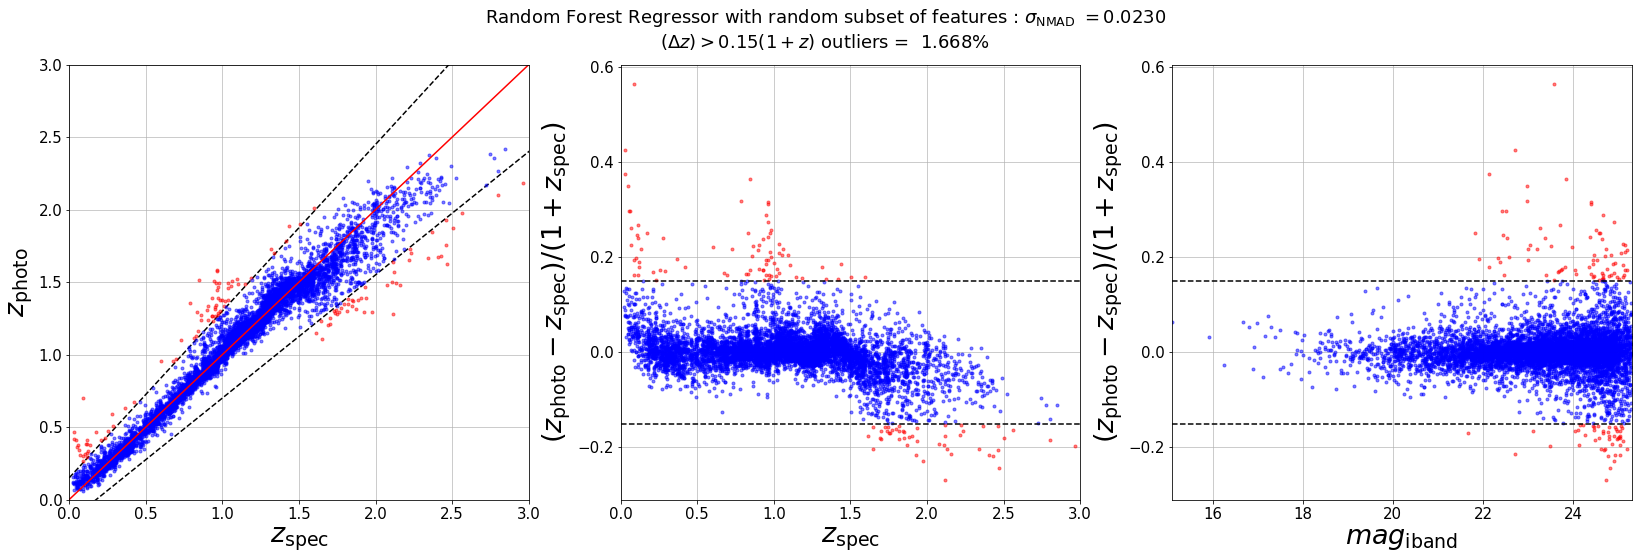

In [32]:
plot_and_stats(test_z, z_phot_bis, test_data_mags[:, 3], title='Random Forest Regressor with random subset of features')
r2_ML_bis = r2_score(z_phot_bis, test_z)
mae_ML_bis = mean_absolute_error(z_phot_bis, test_z)
mse_ML_bis = np.sqrt(mean_squared_error(z_phot_bis, test_z))
print('Random Forest Regressor with random subset of features:\nR2 score: {}, Mean Absolute Error: {}, Mean Squared Error: {}'.format(r2_ML_bis, mae_ML_bis, mse_ML_bis))

DEBUG: zphot size = (3755,), zspec size = (3755,)
Random Forest Regressor Bis on training data :
Standard Deviation: 0.0184
Standard Deviation Uncertainty: 0.0002
Normalized MAD: 0.0084
Delta z >0.15(1+z) outliers:  0.080 percent
Median offset:  0.000 +/-  0.000


Random Forest Regressor Bis on training data:
R2 score: 0.9882609573661001, Mean Absolute Error: 0.029870808281404218, Mean Squared Error: 0.04959107673684666


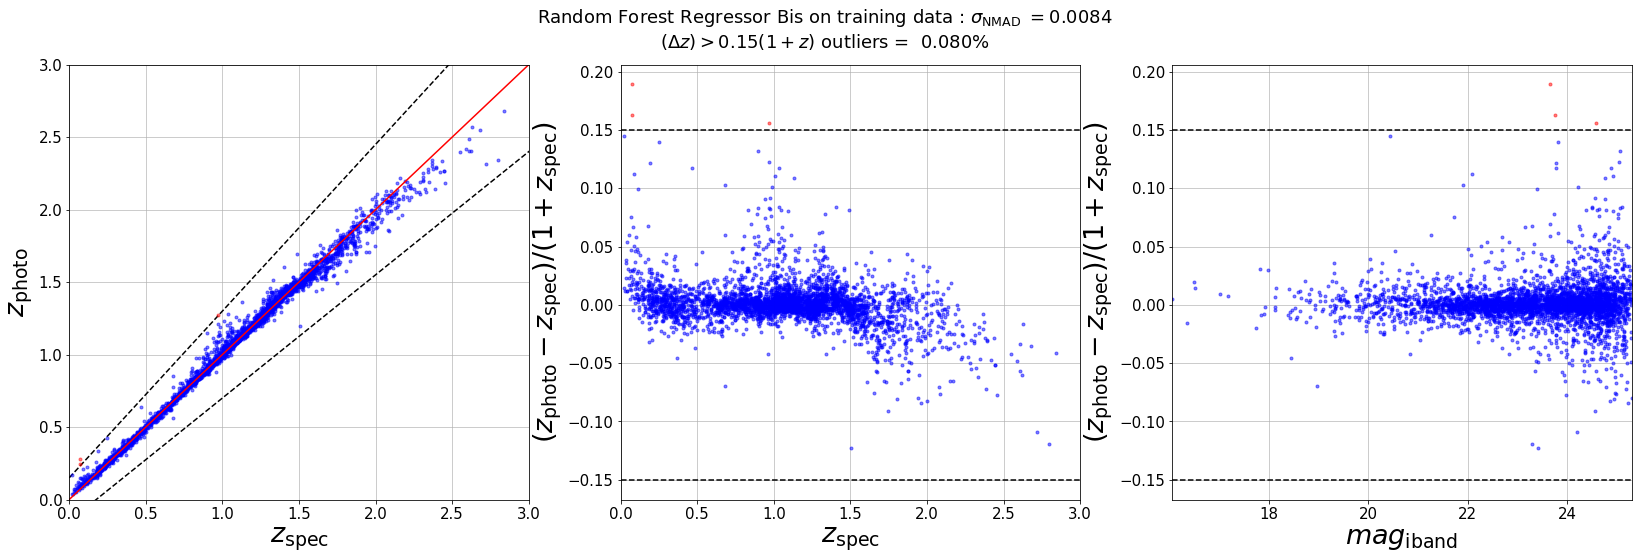

In [34]:
z_phot_train_bis = regrn_bis.predict(train_data_all)
plot_and_stats(train_z.ravel(), z_phot_train_bis, train_data_mags[:, 3], title='Random Forest Regressor Bis on training data')
r2_MLbis_train = r2_score(z_phot_train_bis, train_z)
mae_MLbis_train = mean_absolute_error(z_phot_train_bis, train_z)
mse_MLbis_train = np.sqrt(mean_squared_error(z_phot_train_bis, train_z))
print('Random Forest Regressor Bis on training data:\nR2 score: {}, Mean Absolute Error: {}, Mean Squared Error: {}'.format(r2_ML_train, mae_ML_train, mse_ML_train))